In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

In [2]:
'''
data load
순서대로
노드(2153),
평일, 주말, 평일 6~9, 평일 17~20
'''
nodes = pd.read_csv('../data/station(21.01.31).csv')
links = np.load('../raw_data/data_2_weekday.npy', allow_pickle = True)
links_on = np.load('../raw_data/data_2_on.npy', allow_pickle = 1)
links_off = np.load('../raw_data/data_2_off.npy', allow_pickle = 1)

links = np.array([links[:,1],links[:,3]]).T
links1 = np.array([links_on[:,1],links_on[:,3]]).T
links2 = np.array([links_off[:,1],links_off[:,3]]).T

In [125]:
'''
location
networkx가 위치를 dict로 받기 때문에 raw data를 dict로 바꿈
'''
location = {}
for x,y,z in zip(nodes['station number'], nodes['latitude'], nodes['longitude']):
    location[x] = [z, y]

def weight(network, zoom):
    '''
    weight의 정배수로 network를 그리면 edge가 너무 비대해져서
    zoom 만큼 곱한 값을 나타냄.
    network에 바로 곱하면 오류나서 사용함.
    '''
    weights = nx.get_edge_attributes(network, 'number').values()
    weights = list(weights)
    for i in range(len(weights)):
        weights[i] = weights[i]* zoom
    return weights

# n 보다 큰 것만 생각하기
def new_links(data, n):
    data = data[data['number'] > n]
    return data

# 시작, 끝, count 만 나타내는 리스트 만들기
def simple_list(data):
    a = np.array([data[:,0],data[:,1]]).T.astype(int)

    item = np.unique(a, return_counts=True, axis = 0)[0]
    count = np.unique(a, return_counts=True, axis = 0)[1]

    return np.column_stack((item, count))

def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = location[coord1]
    lat2, lon2 = location[coord2]
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [11]:
# simplify links
s_links = simple_list(links)
s_links1 = simple_list(links1)
s_links2 = simple_list(links2)

# all network
G = nx.DiGraph()
G.add_weighted_edges_from(s_links)

# on network
G1 = nx.DiGraph()
G1.add_weighted_edges_from(s_links1)

#off network
G2 = nx.DiGraph()
G2.add_weighted_edges_from(s_links2)

# shortest pasth

In [ ]:
# calculate shortest path
short1 = nx.shortest_path(G1)
short2 = nx.shortest_path(G2)

# add shortest path value, real distance
for i in short1:
    for j in short1[i]:
        if i == j:
            short1[i][j] = 0
        try:
            short1[i][j] = [len(short1[i][j])-1, haversine(i, j)]
        except:
            pass

for i in short2:
    for j in short2[i]:
        if i == j:
            short2[i][j] = 0
        try:
            short2[i][j] = [len(short2[i][j])-1, haversine(i, j)]
        except:
            pass

In [139]:
# histo 
lili1 = []
lili2 = []
for i in short1:
    for j in short1[i]:
        try:
            lili1.append(short1[i][j][0])
        except:
            pass

for i in short2:
    for j in short2[i]:
        try:
            lili2.append(short2[i][j][0])
        except:
            pass

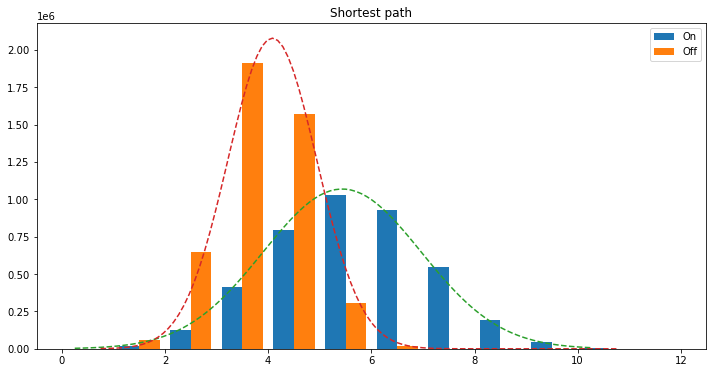

In [140]:
# gaussian fitting
mu_1 = np.average(lili1)
sigma_1 = np.std(lili1)
mu_2 = np.average(lili2)
sigma_2 = np.std(lili2)

con_bins = np.linspace(0, 10, 100)

y_1 = ((1 / (np.sqrt(2 * np.pi) * sigma_1)) * np.exp(-0.5 * (1 / sigma_1 * (con_bins - mu_1))**2))
y_2 = ((1 / (np.sqrt(2 * np.pi) * sigma_2)) * np.exp(-0.5 * (1 / sigma_2 * (con_bins - mu_2))**2))

# shortest path histogram
plt.figure(figsize = (12, 6))

plt.hist([lili1, lili2], bins = [0,1,2,3,4,5,6,7,8,9,10,11,12], label=['On', 'Off'])

plt.plot(con_bins+0.25, y_1*4100000, '--')
plt.plot(con_bins+0.75, y_2*4500000, '--')

plt.title('Shortest path')
plt.legend()
plt.show()

# distance

In [129]:
# histo 
di_1 = []
di_2 = []
for i in short1:
    for j in short1[i]:
        try:
            di_1.append(short1[i][j][1])
        except:
            pass

for i in short2:
    for j in short2[i]:
        try:
            di_2.append(short2[i][j][1])
        except:
            pass

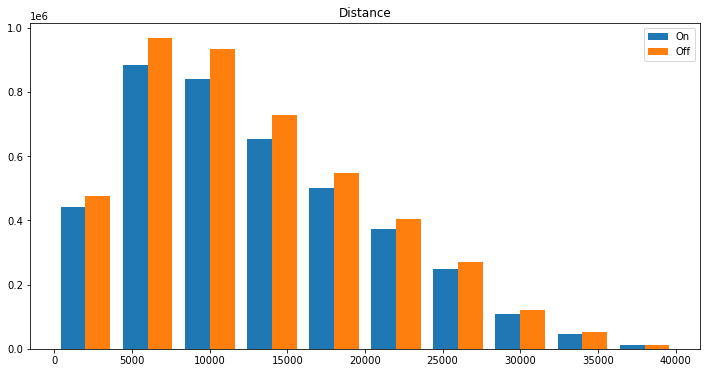

In [135]:
# distance histogram
plt.figure(figsize = (12, 6))

bins = np.linspace(0, 40000, 11)

plt.hist([di_1, di_2], bins=bins, label=['On', 'Off'])

plt.title('Distance')
plt.legend()
plt.show()

# strength

In [137]:
# add in, out weight to nodes
for u in G.nodes:
    G.nodes[u]['in'] = 0
    G.nodes[u]['out'] = 0
for u in G1.nodes:
    G1.nodes[u]['in'] = 0
    G1.nodes[u]['out'] = 0
for u in G2.nodes:
    G2.nodes[u]['in'] = 0
    G2.nodes[u]['out'] = 0

# calculate weight to nodes
for u, v, weight in G.edges(data="weight"):
    G.nodes[u]['in'] += weight
    G.nodes[v]['out'] += weight
for u, v, weight in G1.edges(data="weight"):
    G1.nodes[u]['in'] += weight
    G1.nodes[v]['out'] += weight
for u, v, weight in G2.edges(data="weight"):
    G2.nodes[u]['in'] += weight
    G2.nodes[v]['out'] += weight

# node weight save. node 순서대로
all_in_weight = []
all_out_weight = []
for i in G.nodes:
    if G.nodes[i]['in'] > 0:
        all_in_weight.append(G.nodes[i]['in'])
    else:
        all_in_weight.append(0)
    if G.nodes[i]['out'] > 0:
        all_out_weight.append(G.nodes[i]['out'])
    else:
        all_out_weight.append(0)

on_in_weight = []
on_out_weight = []
for i in G1.nodes:
    if G1.nodes[i]['in'] > 0:
        on_in_weight.append(G1.nodes[i]['in'])
    else:
        on_in_weight.append(0)
    if G1.nodes[i]['out'] > 0:
        on_out_weight.append(G1.nodes[i]['out'])
    else:
        on_out_weight.append(0)

off_in_weight = []
off_out_weight = []
for i in G2.nodes:
    if G2.nodes[i]['in'] > 0:
        off_in_weight.append(G2.nodes[i]['in'])
    else:
        off_in_weight.append(0)
    if G2.nodes[i]['out'] > 0:
        off_out_weight.append(G2.nodes[i]['out'])
    else:
        off_out_weight.append(0)

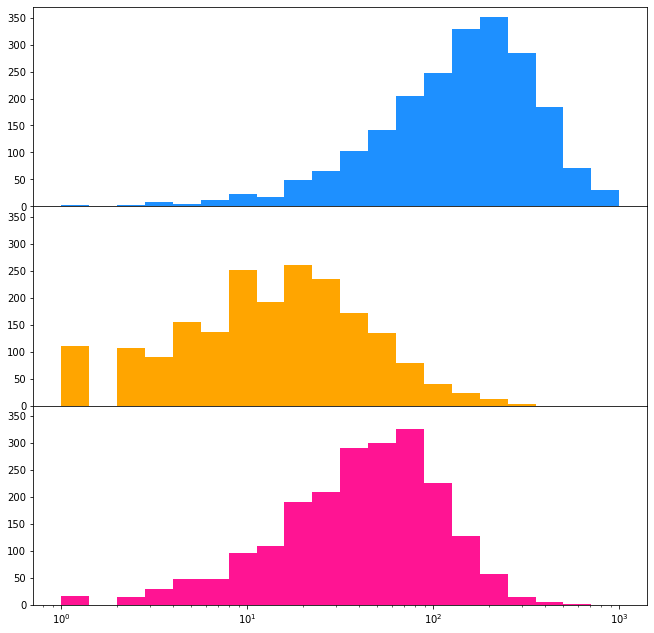

In [149]:
# 노드 웨이트 히스토그램 
bins = np.logspace(0, 3, 21)

# Three subplots sharing both x/y axes
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(11, 11))
ax1.hist([d for d in all_out_weight], bins=bins, color = 'dodgerblue')
ax2.hist([d for d in on_out_weight], bins=bins, color = 'orange')
ax3.hist([d for d in off_out_weight], bins=bins, color = 'deeppink')

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

# y축 퍼센트로 출력
import matplotlib.ticker as ticker
#ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1053))
ax1.set_xscale("log")

plt.show()

/Users/lee/opt/anaconda3/lib/python3.8/site-packages/matplotlib/patches.py:2993: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


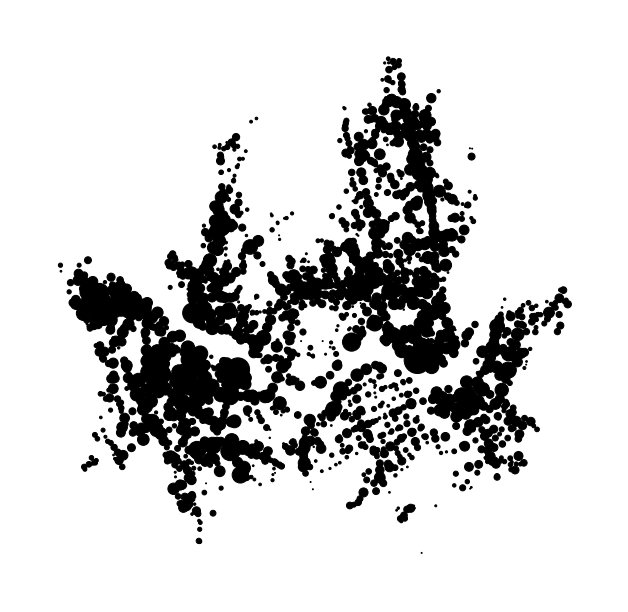

In [138]:
'''
Network : G1, G2
node_size:G1(on_in_weight, on_out_weight)
          G2(off_in_weight, off_out_weight)
'''

plt.figure(figsize = (11,11))

nx.draw_networkx(G2,
                 location, 
                 node_color='black', 
                 node_size=off_out_weight, 
                 with_labels = False, 
                 arrowsize = 0,
                 width = 0.1)
plt.axis('off')
plt.show()